<a href="https://colab.research.google.com/github/isshii/de4test/blob/test_ozawa/DeepXplore/DeepXplore_03_11_result_out.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# 共通で使うパスなどの定義
# 共通の変数設定
# 共通フォルダパス

import datetime
import pytz
dt_now = datetime.datetime.now(pytz.timezone('Asia/Tokyo'))
dt_str = str(dt_now.strftime('%Y%m%d_%H%M'))

data_dir = "/content/gdrive/My Drive/ColabNotebooks/test4ai/data"
#data_imagenet = "/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet"
data_mnist = "/content/gdrive/My Drive/ColabNotebooks/test4ai/data/MNIST"
#data_imagenet_seeds = "/content/gdrive/My Drive/ColabNotebooks/test4ai/data/ImageNet/seeds"
model_dir = "/content/gdrive/My Drive/ColabNotebooks/test4ai/model"
#output_dir = "/content/gdrive/My Drive/ColabNotebooks/test4ai/output"
output_dir = "/content/gdrive/My Drive/ColabNotebooks/test4ai/output/" + dt_str
tmp_dir = "/content/gdrive/My Drive/ColabNotebooks/test4ai/tmp"


In [2]:

# Goggle Drive つなぐ
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# outputフォルダ内容物のクリーンアップ削除
!mkdir "$output_dir"
!rm "$output_dir"/*

rm: cannot remove '/content/gdrive/My Drive/ColabNotebooks/test4ai/output/20200123_1952/*': No such file or directory


In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/ColabNotebooks/test4ai/model/MNIST')

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [5]:
import argparse
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format

%tensorflow_version 1.x
from keras.datasets import mnist
from keras.layers import Input
import imageio

from __future__ import print_function

from keras.datasets import mnist
from keras.layers import Convolution2D, MaxPooling2D, Input, Dense, Activation, Flatten
from keras.models import Model
from keras.utils import to_categorical
import os

# TensorFlowでGPUを使っているかのチェック：
# "device_type: "GPU" " があればOK
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

Using TensorFlow backend.


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10643032179482315373, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12830089441812830657
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 6691896190850280725
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14912199066
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17227525787459490833
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [6]:
#@title デフォルトのタイトル テキスト
# DeepXplore のパラメータ設定部
# read the parameter
# argument parsing
parser = argparse.ArgumentParser(description='Main function for difference-inducing input generation in MNIST dataset')
parser.add_argument('transformation', help="realistic transformation type", choices=['light', 'occl', 'blackout'])
parser.add_argument('weight_diff', help="weight hyperparm to control differential behavior", type=float)
parser.add_argument('weight_nc', help="weight hyperparm to control neuron coverage", type=float)
parser.add_argument('step', help="step size of gradient descent", type=float)
parser.add_argument('seeds', help="number of seeds of input", type=int)
parser.add_argument('grad_iterations', help="number of iterations of gradient descent", type=int)
parser.add_argument('threshold', help="threshold for determining neuron activated", type=float)
parser.add_argument('-t', '--target_model', help="target model that we want it predicts differently",
                    choices=[0, 1, 2], default=0, type=int)
parser.add_argument('-sp', '--start_point', help="occlusion upper left corner coordinate", default=(0, 0), type=tuple)
parser.add_argument('-occl_size', '--occlusion_size', help="occlusion size", default=(10, 10), type=tuple)

_StoreAction(option_strings=['-occl_size', '--occlusion_size'], dest='occlusion_size', nargs=None, const=None, default=(10, 10), type=<class 'tuple'>, choices=None, help='occlusion size', metavar=None)

In [0]:
#@title ノイズのタイプ light / occl / blackout
#@body {light,occl,blackout} weight_diff weight_nc step seeds
#                   grad_iterations threshold
noise_type = "light" #@param ["light", "occl", "blackout"]
weight_diff = "0.1" #@param {type:"string"}
weight_nc = "0.1" #@param {type:"string"}
step = "20" #@param {type:"string"}　#50だとほぼ白飛び
seeds = "5" #@param {type:"string"}
grad_iterations = "10" #@param {type:"string"}
threshold = "0.1" #@param {type:"string"}

In [0]:
args = parser.parse_args([noise_type, weight_diff, weight_nc, step, seeds, grad_iterations, threshold])

In [0]:
import random
from collections import defaultdict

import numpy as np
from keras import backend as K
from keras.models import Model


# util function to convert a tensor into a valid image
def deprocess_image(x):
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x.reshape(x.shape[1], x.shape[2])  # original shape (1,img_rows, img_cols,1)


def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)


def constraint_occl(gradients, start_point, rect_shape):
    new_grads = np.zeros_like(gradients)
    new_grads[:, start_point[0]:start_point[0] + rect_shape[0],
    start_point[1]:start_point[1] + rect_shape[1]] = gradients[:, start_point[0]:start_point[0] + rect_shape[0],
                                                     start_point[1]:start_point[1] + rect_shape[1]]
    return new_grads


def constraint_light(gradients):
    new_grads = np.ones_like(gradients)
    grad_mean = np.mean(gradients)
    return grad_mean * new_grads


def constraint_black(gradients, rect_shape=(6, 6)):
    start_point = (
        random.randint(0, gradients.shape[1] - rect_shape[0]), random.randint(0, gradients.shape[2] - rect_shape[1]))
    new_grads = np.zeros_like(gradients)
    patch = gradients[:, start_point[0]:start_point[0] + rect_shape[0], start_point[1]:start_point[1] + rect_shape[1]]
    if np.mean(patch) < 0:
        new_grads[:, start_point[0]:start_point[0] + rect_shape[0],
        start_point[1]:start_point[1] + rect_shape[1]] = -np.ones_like(patch)
    return new_grads


def init_coverage_tables(model1, model2, model3):
    model_layer_dict1 = defaultdict(bool)
    model_layer_dict2 = defaultdict(bool)
    model_layer_dict3 = defaultdict(bool)
    init_dict(model1, model_layer_dict1)
    init_dict(model2, model_layer_dict2)
    init_dict(model3, model_layer_dict3)
    return model_layer_dict1, model_layer_dict2, model_layer_dict3


def init_dict(model, model_layer_dict):
    for layer in model.layers:
        if 'flatten' in layer.name or 'input' in layer.name:
            continue
        for index in range(layer.output_shape[-1]):
            model_layer_dict[(layer.name, index)] = False


def neuron_to_cover(model_layer_dict):
    not_covered = [(layer_name, index) for (layer_name, index), v in model_layer_dict.items() if not v]
    if not_covered:
        layer_name, index = random.choice(not_covered)
    else:
        layer_name, index = random.choice(model_layer_dict.keys())
    return layer_name, index


def neuron_covered(model_layer_dict):
    covered_neurons = len([v for v in model_layer_dict.values() if v])
    total_neurons = len(model_layer_dict)
    return covered_neurons, total_neurons, covered_neurons / float(total_neurons)


def update_coverage(input_data, model, model_layer_dict, threshold=0):
    layer_names = [layer.name for layer in model.layers if
                   'flatten' not in layer.name and 'input' not in layer.name]

    intermediate_layer_model = Model(inputs=model.input,
                                     outputs=[model.get_layer(layer_name).output for layer_name in layer_names])
    intermediate_layer_outputs = intermediate_layer_model.predict(input_data)

    for i, intermediate_layer_output in enumerate(intermediate_layer_outputs):
        scaled = scale(intermediate_layer_output[0])
        for num_neuron in range(scaled.shape[-1]):
            if np.mean(scaled[..., num_neuron]) > threshold and not model_layer_dict[(layer_names[i], num_neuron)]:
                model_layer_dict[(layer_names[i], num_neuron)] = True


def full_coverage(model_layer_dict):
    if False in model_layer_dict.values():
        return False
    return True


def scale(intermediate_layer_output, rmax=1, rmin=0):
    X_std = (intermediate_layer_output - intermediate_layer_output.min()) / (
        intermediate_layer_output.max() - intermediate_layer_output.min())
    X_scaled = X_std * (rmax - rmin) + rmin
    return X_scaled


def fired(model, layer_name, index, input_data, threshold=0):
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    intermediate_layer_output = intermediate_layer_model.predict(input_data)[0]
    scaled = scale(intermediate_layer_output)
    if np.mean(scaled[..., index]) > threshold:
        return True
    return False


def diverged(predictions1, predictions2, predictions3, target):
    #     if predictions2 == predictions3 == target and predictions1 != target:
    if not predictions1 == predictions2 == predictions3:
        return True
    return False


#add
def list_pictures(directory, ext='jpg|jpeg|bmp|png|ppm'):
    return [os.path.join(root, f)
            for root, _, files in os.walk(directory) for f in files
            if re.match(r'([\w]+\.(?:' + ext + '))', f.lower())]

In [10]:
'''
LeNet-1
'''
def Model1(input_tensor=None, train=False):
    nb_classes = 10
    # convolution kernel size
    kernel_size = (5, 5)

    if train:
        batch_size = 256
        nb_epoch = 1

        # input image dimensions
        img_rows, img_cols = 28, 28

        # the data, shuffled and split between train and test sets
        (x_train, y_train), (x_test, y_test) = mnist.load_data()

        print(x_train.shape)
        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)

        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        x_train /= 255
        x_test /= 255

        # convert class vectors to binary class matrices
        y_train = to_categorical(y_train, nb_classes)
        y_test = to_categorical(y_test, nb_classes)

        input_tensor = Input(shape=input_shape)
    elif input_tensor is None:
        print(bcolors.FAIL + 'you have to proved input_tensor when testing')
        exit()

    # block1
    x = Convolution2D(4, kernel_size, activation='relu', padding='same', name='block1_conv1')(input_tensor)
    x = MaxPooling2D(pool_size=(2, 2), name='block1_pool1')(x)

    # block2
    x = Convolution2D(12, kernel_size, activation='relu', padding='same', name='block2_conv1')(x)
    x = MaxPooling2D(pool_size=(2, 2), name='block2_pool1')(x)

    x = Flatten(name='flatten')(x)
    x = Dense(nb_classes, name='before_softmax')(x)
    x = Activation('softmax', name='predictions')(x)

    model = Model(input_tensor, x)

    if train:
        # compiling
        model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

        # trainig
        model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=nb_epoch, verbose=1)
        # save model
#        model.save_weights('./Model1.h5')
        model.save_weights('/content/gdrive/My Drive/ColabNotebooks/test4ai/model/MNIST/Model1.h5')
        score = model.evaluate(x_test, y_test, verbose=0)
        print('\n')
        print('Overall Test score:', score[0])
        print('Overall Test accuracy:', score[1])
    else:
#        model.load_weights('./Model1.h5')
        model.load_weights('/content/gdrive/My Drive/ColabNotebooks/test4ai/model/MNIST/Model1.h5')
        print(bcolors.OKBLUE + 'Model1 loaded' + bcolors.ENDC)

    return model


if __name__ == '__main__':
    Model1(train=True)


(60000, 28, 28)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 60000 samples, validate on 10000 samples
Epoch 1/1





60000/60000 [==============================] - 4s 73us/step - loss: 0.4524 - acc: 0.8629 - val_loss: 0.1452 - val_acc: 0.9581


Overall Test score: 0.14523715103194118
Overall Test accuracy: 0.9581


In [11]:
'''
LeNet-4
'''
def Model2(input_tensor=None, train=False):
    nb_classes = 10
    # convolution kernel size
    kernel_size = (5, 5)

    if train:
        batch_size = 256
        nb_epoch = 1

        # input image dimensions
        img_rows, img_cols = 28, 28

        # the data, shuffled and split between train and test sets
        (x_train, y_train), (x_test, y_test) = mnist.load_data()

        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)

        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        x_train /= 255
        x_test /= 255

        # convert class vectors to binary class matrices
        y_train = to_categorical(y_train, nb_classes)
        y_test = to_categorical(y_test, nb_classes)

        input_tensor = Input(shape=input_shape)
    elif input_tensor is None:
        print(bcolors.FAIL + 'you have to proved input_tensor when testing')
        exit()

    # block1
    x = Convolution2D(6, kernel_size, activation='relu', padding='same', name='block1_conv1')(input_tensor)
    x = MaxPooling2D(pool_size=(2, 2), name='block1_pool1')(x)

    # block2
    x = Convolution2D(16, kernel_size, activation='relu', padding='same', name='block2_conv1')(x)
    x = MaxPooling2D(pool_size=(2, 2), name='block2_pool1')(x)

    x = Flatten(name='flatten')(x)
    x = Dense(84, activation='relu', name='fc1')(x)
    x = Dense(nb_classes, name='before_softmax')(x)
    x = Activation('softmax', name='predictions')(x)

    model = Model(input_tensor, x)

    if train:
        # compiling
        model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

        # trainig
        model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=nb_epoch, verbose=1)
        # save model
        model.save_weights('./Model2.h5')
        score = model.evaluate(x_test, y_test, verbose=0)
        print('\n')
        print('Overall Test score:', score[0])
        print('Overall Test accuracy:', score[1])
    else:
        model.load_weights('./Model2.h5')
        print(bcolors.OKBLUE + 'Model2 loaded' + bcolors.ENDC)

    return model


if __name__ == '__main__':
    Model2(train=True)


Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 2s 32us/step - loss: 0.3506 - acc: 0.8935 - val_loss: 0.2616 - val_acc: 0.9157


Overall Test score: 0.2616416467715055
Overall Test accuracy: 0.9157


In [12]:
'''
LeNet-5
'''
def Model3(input_tensor=None, train=False):
    nb_classes = 10
    # convolution kernel size
    kernel_size = (5, 5)

    if train:
        batch_size = 256
        nb_epoch = 1

        # input image dimensions
        img_rows, img_cols = 28, 28

        # the data, shuffled and split between train and test sets
        (x_train, y_train), (x_test, y_test) = mnist.load_data()

        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)

        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        x_train /= 255
        x_test /= 255

        # convert class vectors to binary class matrices
        y_train = to_categorical(y_train, nb_classes)
        y_test = to_categorical(y_test, nb_classes)

        input_tensor = Input(shape=input_shape)
    elif input_tensor is None:
        print(bcolors.FAIL + 'you have to proved input_tensor when testing')
        exit()

    # block1
    x = Convolution2D(6, kernel_size, activation='relu', padding='same', name='block1_conv1')(input_tensor)
    x = MaxPooling2D(pool_size=(2, 2), name='block1_pool1')(x)

    # block2
    x = Convolution2D(16, kernel_size, activation='relu', padding='same', name='block2_conv1')(x)
    x = MaxPooling2D(pool_size=(2, 2), name='block2_pool1')(x)

    x = Flatten(name='flatten')(x)
    x = Dense(120, activation='relu', name='fc1')(x)
    x = Dense(84, activation='relu', name='fc2')(x)
    x = Dense(nb_classes, name='before_softmax')(x)
    x = Activation('softmax', name='predictions')(x)

    model = Model(input_tensor, x)

    if train:
        # compiling
        model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

        # trainig
        model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=nb_epoch, verbose=1)
        # save model
        model.save_weights('./Model3.h5')
        score = model.evaluate(x_test, y_test, verbose=0)
        print('\n')
        print('Overall Test score:', score[0])
        print('Overall Test accuracy:', score[1])
    else:
        model.load_weights('./Model3.h5')
        print(bcolors.OKBLUE + 'Model3 loaded' + bcolors.ENDC)

    return model


if __name__ == '__main__':
    Model3(train=True)


Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 2s 36us/step - loss: 0.3647 - acc: 0.8838 - val_loss: 0.1585 - val_acc: 0.9509


Overall Test score: 0.1585128423959017
Overall Test accuracy: 0.9509


In [13]:
# input MNIST image dimensions 
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)
input_tensor = Input(shape=input_shape)

#define the model instance
model1 = Model1(input_tensor=input_tensor)
model2 = Model2(input_tensor=input_tensor)
model3 = Model3(input_tensor=input_tensor)

#define the dictionary of neuron coverage
model_layer_dict1, model_layer_dict2, model_layer_dict3 = init_coverage_tables(model1, model2, model3)

Model1 loaded
Model2 loaded
Model3 loaded


### 入力するデータの選別(1/2)

０～９の数字をそれぞれ束ねてデータを準備する
[00...011...1......99...9]。

* test_per_fig_x: 
    各数字に対する画像データを格納
* test_per_fig_y: 
    各数字に対する教師ラベルを格納
* tests_x: 
    test_per_fig_xを数字ごとに格納：deepXploreコアコードのseedsに使う
* tests_y: 
    tests_xの正解ラベル

In [14]:
# load the MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

num_fig = 10
test_per_fig_x = np.array([])
test_per_fig_y = np.array([])
tests_x = np.array([])
tests_y = np.array([])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train = x_train.astype('float')
#x_test = x_test.astype('float')
x_train /= 255
x_test /= 255

length = int(args.seeds)
#length = int(args.seeds)
for i in range(num_fig):
  cond = [(x==i) for x in y_test]
  test_per_fig_x = x_test[cond]
  test_per_fig_y = y_test[cond]
#  np.set_printoptions(formatter={'int': '{:07d}'.format})
  print("figure:", i, ", shape:", test_per_fig_x.shape, ", deviation:",test_per_fig_x.shape[0]-1000)
  tests_x = np.append(tests_x, test_per_fig_x[:length])
  tests_y = np.append(tests_y, test_per_fig_y[:length])
#  conds = [conds, cond]
print("check!", tests_x.shape[0]/img_rows/img_cols/num_fig, "=", length, "equal?")

###### MNIST data, shuffled and split by train and test sets
#####(_, _), (x_test, _) = mnist.load_data()

###### modify the numpy data for the Keras model
#####x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
#####input_shape = (img_rows, img_cols, 1)

tests_x = tests_x.reshape(-1,img_rows, img_cols,1)
#tests_x.shape
tests_x = tests_x.astype('float32')

figure: 0 , shape: (980, 28, 28) , deviation: -20
figure: 1 , shape: (1135, 28, 28) , deviation: 135
figure: 2 , shape: (1032, 28, 28) , deviation: 32
figure: 3 , shape: (1010, 28, 28) , deviation: 10
figure: 4 , shape: (982, 28, 28) , deviation: -18
figure: 5 , shape: (892, 28, 28) , deviation: -108
figure: 6 , shape: (958, 28, 28) , deviation: -42
figure: 7 , shape: (1028, 28, 28) , deviation: 28
figure: 8 , shape: (974, 28, 28) , deviation: -26
figure: 9 , shape: (1009, 28, 28) , deviation: 9
check! 5.0 = 5 equal?


## 入力するデータの選別(2/2)
０～９の数字をそれぞれ束ねてデータを準備する [00...000]。

* test_per_fig_x: 各数字に対する画像データを格納
* test_per_fig_y: 各数字に対する教師ラベルを格納
* tests_x: test_per_fig_xを数字ごとに格納：deepXploreコアコードのseedsに使う
* tests_y: tests_xの正解ラベル

In [0]:
#@title デフォルトのタイトル テキスト
#load the MNIST 

def create_data(start_fig, num_fi, length):
  (datax_train, y_train), (x_test, y_test) = mnist.load_data()
  test_per_fig_x = np.array([])
  test_per_fig_y = np.array([])
  tests_x = np.array([])
  tests_y = np.array([])

  x_train = x_train.astype('float32')
  x_test  = x_test.astype('float32')
  x_train = x_train.astype('float')
  x_test = x_test.astype('float')
  x_train /= 255
  x_test /= 255
  #length = int(args.seeds/num_fig)
  #length = int(args.seeds)
  for i in range(start_fig, start_fig+num_fig):
  #i=0
    cond = [(x==i) for x in y_test]
    test_per_fig_x = x_test[cond]
    test_per_fig_y = y_test[cond]
    print("figure:", i, ", shape:", test_per_fig_x.shape, ", deviation:",test_per_fig_x.shape[0]-1000)
    tests_x = np.append(tests_x, test_per_fig_x[:length])
    tests_y = np.append(tests_y, test_per_fig_y[:length])  

  #conds = [conds, cond]
  print("check!", tests_x.shape[0]/img_rows/img_cols/num_fig, "=", length, "equal?")
  tests_x = tests_x.reshape(-1,img_rows, img_cols,1)
  tests_x.shape
  tests_x = tests_x.astype('float32')
  return tests_x, tests_y, length
  tests_x, tests_y, length = create_data(0, 10, int(args.seeds))

In [16]:
print(tests_x.shape)
print(tests_y)
for i in range(0,1):
  print(i)
print(length)

(50, 28, 28, 1)
[0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 4. 4. 4. 4.
 4. 5. 5. 5. 5. 5. 6. 6. 6. 6. 6. 7. 7. 7. 7. 7. 8. 8. 8. 8. 8. 9. 9. 9.
 9. 9.]
0
5


In [17]:
%%time

def neuron_output(input_data, model, model_layer_dict, threshold=0):
    layer_names = [layer.name for layer in model.layers if
                   'flatten' not in layer.name and 'input' not in layer.name]

    intermediate_layer_model = Model(inputs=model.input,
                                     outputs=[model.get_layer(layer_name).output for layer_name in layer_names])
    intermediate_layer_outputs = intermediate_layer_model.predict(input_data)
    
    out_list = []
    out_list_scale = []
    for i, intermediate_layer_output in enumerate(intermediate_layer_outputs):
        scaled = scale(intermediate_layer_output[0])
        for num_neuron in range(scaled.shape[-1]):
            out_list.append(np.mean(intermediate_layer_output[..., num_neuron]))
            out_list_scale.append(np.mean(scaled[..., num_neuron]))

    return out_list, out_list_scale


def deepXplore(model_layer_dict1, model_layer_dict2, model_layer_dict3, tests_x, model1, model2, model3, num_fig, start_fig, length):
  #print("test01")
  count_already = 0
  count_found = 0
  count_not_found = 0
  temp_per_nc1 = np.array([])
  temp_per_nc2 = np.array([])
  temp_per_nc3 = np.array([])
  temp_num_nc1 = np.array([])
  temp_num_nc2 = np.array([])
  temp_num_nc3 = np.array([])
  #print("test10")

  #for each neuron
  num_neurons1 = neuron_covered(model_layer_dict1)[1]
  num_neurons2 = neuron_covered(model_layer_dict2)[1]
  num_neurons3 = neuron_covered(model_layer_dict3)[1]
  #print("test11")

  column_tmp1 = list(model_layer_dict1.keys())
  column_tmp2 = list(model_layer_dict2.keys())
  column_tmp3 = list(model_layer_dict3.keys())
  #print("test12")
  df1 = pd.DataFrame(columns=column_tmp1)
  df2 = pd.DataFrame(columns=column_tmp2)
  df3 = pd.DataFrame(columns=column_tmp3)
  df1_scale = pd.DataFrame(columns=column_tmp1)
  df2_scale = pd.DataFrame(columns=column_tmp2)
  df3_scale = pd.DataFrame(columns=column_tmp3)
  tmp_list = ["already_diff", "found", "not_found", "layer1", "index1", "layer2", "index2", "layer3", "index3"]
  bug_result = pd.DataFrame(columns=tmp_list)
  trial = 1
  #print("test13")
  #print("test02")
  for index_fig in range(num_fig):
    index_fig = index_fig + start_fig
    print("figure"+str(index_fig))
    for _ in range(length):
      #gen_img = np.expand_dims(random.choice(tests_x), axis=0)
      gen_img = np.expand_dims(tests_x[(length*index_fig + _)], axis=0)
      orig_img = gen_img.copy()
      # first check if input already induces differences
      label1, label2, label3 = np.argmax(model1.predict(gen_img)[0]), np.argmax(model2.predict(gen_img)[0]), np.argmax(model3.predict(gen_img)[0])

      if not label1 == label2 == label3:
          count_already += 1
          print(bcolors.OKGREEN + '   {}/{}. input already causes different outputs ({},{},{}) at({}, {}, {}): '.format(_, length, label1, label2, label3, count_already, count_found, count_not_found) + bcolors.ENDC)        

          update_coverage(gen_img, model1, model_layer_dict1, args.threshold)
          update_coverage(gen_img, model2, model_layer_dict2, args.threshold)
          update_coverage(gen_img, model3, model_layer_dict3, args.threshold)

          temp_per_nc1=np.append(temp_per_nc1,  neuron_covered(model_layer_dict1)[2])
          temp_per_nc2=np.append(temp_per_nc2,  neuron_covered(model_layer_dict2)[2])
          temp_per_nc3=np.append(temp_per_nc3,  neuron_covered(model_layer_dict3)[2])
          temp_num_nc1=np.append(temp_num_nc1,  neuron_covered(model_layer_dict1)[0])
          temp_num_nc2=np.append(temp_num_nc2,  neuron_covered(model_layer_dict2)[0])
          temp_num_nc3=np.append(temp_num_nc3,  neuron_covered(model_layer_dict3)[0])
                               
          print(bcolors.OKGREEN + '     covered neurons percentage %d neurons %.3f, %d neurons %.3f, %d neurons %.3f'% (len(model_layer_dict1), neuron_covered(model_layer_dict1)[2], len(model_layer_dict2),
                  neuron_covered(model_layer_dict2)[2], len(model_layer_dict3), neuron_covered(model_layer_dict3)[2]) + bcolors.ENDC)
          averaged_nc = (neuron_covered(model_layer_dict1)[0] + neuron_covered(model_layer_dict2)[0] +
                       neuron_covered(model_layer_dict3)[0]) / float(neuron_covered(model_layer_dict1)[1] + neuron_covered(model_layer_dict2)[1] +neuron_covered(model_layer_dict3)[1])
          print(bcolors.OKGREEN + '     averaged covered neurons %.3f' % (averaged_nc) + bcolors.ENDC)

          gen_img_deprocessed = deprocess_image(gen_img)

          # save the result to disk
          outputfilepath0 = os.path.join(output_dir, 'already_differ_' + str(label1) + '_' + str(label2) + '_' + str(label3) +'_['+ str(_) +  '].png')
          imageio.imwrite(outputfilepath0, gen_img_deprocessed)

          temp, temp_scale = neuron_output(gen_img, model1, model_layer_dict1, args.threshold)
          temp = pd.Series(temp, index=df1.columns, name=str(index_fig) + "_" + str(trial))
          temp_scale = pd.Series(temp_scale, index=df1.columns, name=str(index_fig) + "_" + str(trial))
          df1 = df1.append(temp)
          df1_scale = df1_scale.append(temp_scale)

          temp, temp_scale = neuron_output(gen_img, model2, model_layer_dict2, args.threshold)
          temp = pd.Series(temp, index=df2.columns, name=str(index_fig) + "_" + str(trial))
          temp_scale = pd.Series(temp_scale, index=df2.columns, name=str(index_fig) + "_" + str(trial))
          df2 = df2.append(temp)
          df2_scale = df2_scale.append(temp_scale)

          temp, temp_scale = neuron_output(gen_img, model3, model_layer_dict3, args.threshold)
          temp = pd.Series(temp, index=df3.columns, name=str(index_fig) + "_" + str(trial))
          temp_scale = pd.Series(temp_scale, index=df3.columns, name=str(index_fig) + "_" + str(trial))
          df3 = df3.append(temp)
          df3_scale = df3_scale.append(temp_scale)

          #print("test10")
          temp = [1, 0, 0, None, None, None, None, None, None]
          #print("test11")
          temp = pd.Series(temp, index=bug_result.columns, name=str(index_fig) + "_" + str(trial))
          #print("test12")
          bug_result = bug_result.append(temp)
          #print("test13")
          trial += 1
          continue

      # if all label agrees
      orig_label = label1
      layer_name1, index1 = neuron_to_cover(model_layer_dict1)
      layer_name2, index2 = neuron_to_cover(model_layer_dict2)
      layer_name3, index3 = neuron_to_cover(model_layer_dict3)

      # construct joint loss function
      if args.target_model == 0:
        loss1 = -args.weight_diff * K.mean(model1.get_layer('before_softmax').output[..., orig_label])
        loss2 = K.mean(model2.get_layer('before_softmax').output[..., orig_label])
        loss3 = K.mean(model3.get_layer('before_softmax').output[..., orig_label])
      elif args.target_model == 1:
        loss1 = K.mean(model1.get_layer('before_softmax').output[..., orig_label])
        loss2 = -args.weight_diff * K.mean(model2.get_layer('before_softmax').output[..., orig_label])
        loss3 = K.mean(model3.get_layer('before_softmax').output[..., orig_label])
      elif args.target_model == 2:
        loss1 = K.mean(model1.get_layer('before_softmax').output[..., orig_label])
        loss2 = K.mean(model2.get_layer('before_softmax').output[..., orig_label])
        loss3 = -args.weight_diff * K.mean(model3.get_layer('before_softmax').output[..., orig_label])
      loss1_neuron = K.mean(model1.get_layer(layer_name1).output[..., index1])
      loss2_neuron = K.mean(model2.get_layer(layer_name2).output[..., index2])
      loss3_neuron = K.mean(model3.get_layer(layer_name3).output[..., index3])
      layer_output = (loss1 + loss2 + loss3) + args.weight_nc * (loss1_neuron + loss2_neuron + loss3_neuron)

      # for adversarial image generation
      final_loss = K.mean(layer_output)

      # we compute the gradient of the input picture wrt this loss
      grads = normalize(K.gradients(final_loss, input_tensor)[0])

      # this function returns the loss and grads given the input picture
      iterate = K.function([input_tensor], [loss1, loss2, loss3, loss1_neuron, loss2_neuron, loss3_neuron, grads])

      #print("test03")
      # we run gradient ascent for some steps
      for iters in range(args.grad_iterations):
        loss_value1, loss_value2, loss_value3, loss_neuron1, loss_neuron2, loss_neuron3, grads_value = iterate([gen_img])
        if args.transformation == 'light':
            grads_value = constraint_light(grads_value)  # constraint the gradients value
        elif args.transformation == 'occl':
            grads_value = constraint_occl(grads_value, args.start_point,
                                          args.occlusion_size)  # constraint the gradients value
        elif args.transformation == 'blackout':
            grads_value = constraint_black(grads_value)  # constraint the gradients value

        gen_img += grads_value * args.step
        predictions1 = np.argmax(model1.predict(gen_img)[0])
        predictions2 = np.argmax(model2.predict(gen_img)[0])
        predictions3 = np.argmax(model3.predict(gen_img)[0])

        #print("test04")
        if not predictions1 == predictions2 == predictions3:
            update_coverage(gen_img, model1, model_layer_dict1, args.threshold)
            update_coverage(gen_img, model2, model_layer_dict2, args.threshold)
            update_coverage(gen_img, model3, model_layer_dict3, args.threshold)
            count_found += 1
            print(bcolors.OKBLUE + '%4d/%d. found at %d! covered neurons percentage %d neurons %.3f, %d neurons %.3f, %d neurons %.3f at (%d, %d, %d)'
#                  % (_, args.seeds, iters, len(model_layer_dict1), neuron_covered(model_layer_dict1)[2], len(model_layer_dict2),
                  % (_, length, iters + 1, len(model_layer_dict1), neuron_covered(model_layer_dict1)[2], len(model_layer_dict2),
                     neuron_covered(model_layer_dict2)[2], len(model_layer_dict3),
                     neuron_covered(model_layer_dict3)[2], count_already, count_found, count_not_found) + bcolors.ENDC)
            averaged_nc = (neuron_covered(model_layer_dict1)[0] + neuron_covered(model_layer_dict2)[0] +
                           neuron_covered(model_layer_dict3)[0]) / float(
                neuron_covered(model_layer_dict1)[1] + neuron_covered(model_layer_dict2)[1] +
                neuron_covered(model_layer_dict3)[1])
            print(bcolors.OKBLUE + '     averaged covered neurons %.3f' % averaged_nc + bcolors.ENDC)

            gen_img_deprocessed = deprocess_image(gen_img)
            orig_img_deprocessed = deprocess_image(orig_img)

            # save the result to disk
            #outputfilepath = os.path.join(output_dir, args.transformation + '_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '.png')
            outputfilepath = os.path.join(output_dir, args.transformation + '_from' + str(label1) + '_to' + str(predictions1) + '_'  + str(predictions2) + '_' + str(predictions3) +'_['+ str(_) +  '].png')
            #print(outputfilepath)
            imageio.imwrite(outputfilepath, gen_img_deprocessed)
#            outputfilepath2 = os.path.join(output_dir, args.transformation + '_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '_orig.png')
            outputfilepath2 = os.path.join(output_dir, args.transformation + '_from' + str(label1) + '_to' + str(predictions1) + '_'  + str(predictions2) + '_' + str(predictions3) +'_['+ str(_) +  ']_orig.png')
            #print(outputfilepath2)
            imageio.imwrite(outputfilepath2, orig_img_deprocessed)
            temp_per_nc1=np.append(temp_per_nc1,  neuron_covered(model_layer_dict1)[2])
            temp_per_nc2=np.append(temp_per_nc2,  neuron_covered(model_layer_dict2)[2])
            temp_per_nc3=np.append(temp_per_nc3,  neuron_covered(model_layer_dict3)[2])
            temp_num_nc1=np.append(temp_num_nc1,  neuron_covered(model_layer_dict1)[0])
            temp_num_nc2=np.append(temp_num_nc2,  neuron_covered(model_layer_dict2)[0])
            temp_num_nc3=np.append(temp_num_nc3,  neuron_covered(model_layer_dict3)[0])

            temp, temp_scale = neuron_output(gen_img, model1, model_layer_dict1, args.threshold)
            temp = pd.Series(temp, index=df1.columns, name=str(index_fig) + "_" + str(trial))
            temp_scale = pd.Series(temp_scale, index=df1.columns, name=str(index_fig) + "_" + str(trial))
            df1 = df1.append(temp)
            df1_scale = df1_scale.append(temp_scale)

            temp, temp_scale = neuron_output(gen_img, model2, model_layer_dict2, args.threshold)
            temp = pd.Series(temp, index=df2.columns, name=str(index_fig) + "_" + str(trial))
            temp_scale = pd.Series(temp_scale, index=df2.columns, name=str(index_fig) + "_" + str(trial))
            df2 = df2.append(temp)
            df2_scale = df2_scale.append(temp_scale)

            temp, temp_scale = neuron_output(gen_img, model3, model_layer_dict3, args.threshold)
            temp = pd.Series(temp, index=df3.columns, name=str(index_fig) + "_" + str(trial))
            temp_scale = pd.Series(temp_scale, index=df3.columns, name=str(index_fig) + "_" + str(trial))

            df3 = df3.append(temp)
            df3_scale = df3_scale.append(temp_scale)

            temp = [0, iters+1, 0, layer_name1, index1, layer_name2, index2,layer_name3, index3]
            temp = pd.Series(temp, index=bug_result.columns, name=str(index_fig) + "_" + str(trial))
            bug_result = bug_result.append(temp)
            trial += 1
            break
          
          #add
        #print("test05")
        if iters == (args.grad_iterations-1):
            update_coverage(gen_img, model1, model_layer_dict1, args.threshold)
            update_coverage(gen_img, model2, model_layer_dict2, args.threshold)
            update_coverage(gen_img, model3, model_layer_dict3, args.threshold)
            averaged_nc = (neuron_covered(model_layer_dict1)[0] + neuron_covered(model_layer_dict2)[0] +
                           neuron_covered(model_layer_dict3)[0]) / float(neuron_covered(model_layer_dict1)[1] + neuron_covered(model_layer_dict2)[1] +
                neuron_covered(model_layer_dict3)[1])
            count_not_found += 1
#              print('%4d/%d. test suite was not found: averaged covered neurons %.3f at %d/%d' % (_, args.seeds, averaged_nc, count_not_found, count_already + count_found + count_not_found))
            print('%4d/%d. test suite was not found: averaged covered neurons %.3f at (%d, %d, %d)' % (_, length, averaged_nc, count_already, count_found, count_not_found))

            gen_img_deprocessed = deprocess_image(gen_img)
            #orig_img_deprocessed = deprocess_image(orig_img)

            # save the result to disk
            #outputfilepath = os.path.join(output_dir, args.transformation + '_' + str(label1) + '_' + str(label2) + '_' + str(label3) + '.png')
            outputfilepath = os.path.join(output_dir, 'not_found_' + str(label1)+'_['+ str(_) + '].png')
#           print(outputfilepath)
            imageio.imwrite(outputfilepath, gen_img_deprocessed)

            
            temp, temp_scale = neuron_output(gen_img, model1, model_layer_dict1, args.threshold)
            temp = pd.Series(temp, index=df1.columns, name=str(index_fig) + "_" + str(trial))
            temp_scale = pd.Series(temp_scale, index=df1.columns, name=str(index_fig) + "_" + str(trial))
            df1 = df1.append(temp)
            df1_scale = df1_scale.append(temp_scale)

            temp, temp_scale = neuron_output(gen_img, model2, model_layer_dict2, args.threshold)
            temp = pd.Series(temp, index=df2.columns, name=str(index_fig) + "_" + str(trial))
            temp_scale = pd.Series(temp_scale, index=df2.columns, name=str(index_fig) + "_" + str(trial))
            df2 = df2.append(temp)
            df2_scale = df2_scale.append(temp_scale)

            temp, temp_scale = neuron_output(gen_img, model3, model_layer_dict3, args.threshold)
            temp = pd.Series(temp, index=df3.columns, name=str(index_fig) + "_" + str(trial))
            temp_scale = pd.Series(temp_scale, index=df3.columns, name=str(index_fig) + "_" + str(trial))

            df3 = df3.append(temp)
            df3_scale = df3_scale.append(temp_scale)


            temp = [0, 0, 1, layer_name1, index1, layer_name2, index2,layer_name3, index3]
            temp = pd.Series(temp, index=bug_result.columns, name=str(index_fig) + "_" + str(trial))
            bug_result = bug_result.append(temp)

            trial += 1
            
            #break

            temp_per_nc1=np.append(temp_per_nc1,  neuron_covered(model_layer_dict1)[2])
            temp_per_nc2=np.append(temp_per_nc2,  neuron_covered(model_layer_dict2)[2])
            temp_per_nc3=np.append(temp_per_nc3,  neuron_covered(model_layer_dict3)[2])
            temp_num_nc1=np.append(temp_num_nc1,  neuron_covered(model_layer_dict1)[0])
            temp_num_nc2=np.append(temp_num_nc2,  neuron_covered(model_layer_dict2)[0])
            temp_num_nc3=np.append(temp_num_nc3,  neuron_covered(model_layer_dict3)[0])

  temp_per_nc1=temp_per_nc1.reshape(num_fig, length)
  temp_per_nc2=temp_per_nc2.reshape(num_fig, length)
  temp_per_nc3=temp_per_nc3.reshape(num_fig, length)
  temp_num_nc1=temp_num_nc1.reshape(num_fig, length)
  temp_num_nc2=temp_num_nc2.reshape(num_fig, length)
  temp_num_nc3=temp_num_nc3.reshape(num_fig, length)

  return df1, df2, df3, df1_scale, df2_scale, df3_scale, bug_result

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


In [18]:
print(length, num_fig)
print(output_dir)
column_tmp1 = list(model_layer_dict1.keys())
df1 = pd.DataFrame(columns=column_tmp1)
df1.head()

5 10
/content/gdrive/My Drive/ColabNotebooks/test4ai/output/20200123_1952


,"(block1_conv1, 0)","(block1_conv1, 1)","(block1_conv1, 2)","(block1_conv1, 3)","(block1_pool1, 0)","(block1_pool1, 1)","(block1_pool1, 2)","(block1_pool1, 3)","(block2_conv1, 0)","(block2_conv1, 1)","(block2_conv1, 2)","(block2_conv1, 3)","(block2_conv1, 4)","(block2_conv1, 5)","(block2_conv1, 6)","(block2_conv1, 7)","(block2_conv1, 8)","(block2_conv1, 9)","(block2_conv1, 10)","(block2_conv1, 11)","(block2_pool1, 0)","(block2_pool1, 1)","(block2_pool1, 2)","(block2_pool1, 3)","(block2_pool1, 4)","(block2_pool1, 5)","(block2_pool1, 6)","(block2_pool1, 7)","(block2_pool1, 8)","(block2_pool1, 9)","(block2_pool1, 10)","(block2_pool1, 11)","(before_softmax, 0)","(before_softmax, 1)","(before_softmax, 2)","(before_softmax, 3)","(before_softmax, 4)","(before_softmax, 5)","(before_softmax, 6)","(before_softmax, 7)","(before_softmax, 8)","(before_softmax, 9)","(predictions, 0)","(predictions, 1)","(predictions, 2)","(predictions, 3)","(predictions, 4)","(predictions, 5)","(predictions, 6)","(predictions, 7)","(predictions, 8)","(predictions, 9)"


In [19]:
index_fig = 0
trial = 0
gen_img = np.expand_dims(tests_x[(length*index_fig + 0)], axis=0)
temp, temp_scale = neuron_output(gen_img, model1, model_layer_dict1, args.threshold)
temp_scale = pd.Series(temp_scale, index=df1.columns, name=str(index_fig) + "_" + str(trial))
print(type(temp_scale))
temp_scale.name

<class 'pandas.core.series.Series'>


'0_0'

In [20]:
#num_fig = 1
#start_fig = 0
#deepXplore(model_layer_dict1=model_layer_dict1, model_layer_dict2=model_layer_dict2, model_layer_dict3=model_layer_dict3, tests_x=tests_x, model1=model1, model2=model2, model3=model3, num_fig = num_fig, start_fig=start_fig, length=length)

num_fig = 1
for start_fig in range(10):
#for start_fig in range(2):
  df1, df2, df3, df1_scale, df2_scale, df3_scale, bug_result= deepXplore(model_layer_dict1=model_layer_dict1, model_layer_dict2=model_layer_dict2, model_layer_dict3=model_layer_dict3, tests_x=tests_x, model1=model1, model2=model2, model3=model3, num_fig = num_fig, start_fig=start_fig, length=length)
  df1_scale.to_csv(output_dir+ "/../01_fig" + str(start_fig) + "_seed" + str(length) +"_neuron.csv")
  bug_result.to_csv(output_dir+ "/../01_fig" + str(start_fig) + "_seed" + str(length) +"_index.csv")

figure0
   0/5. found at 9! covered neurons percentage 52 neurons 0.596, 148 neurons 0.486, 268 neurons 0.414 at (0, 1, 0)
     averaged covered neurons 0.457
   1/5. found at 3! covered neurons percentage 52 neurons 0.596, 148 neurons 0.554, 268 neurons 0.422 at (0, 2, 0)
     averaged covered neurons 0.483
   2/5. found at 4! covered neurons percentage 52 neurons 0.615, 148 neurons 0.554, 268 neurons 0.422 at (0, 3, 0)
     averaged covered neurons 0.485
   3/5. found at 10! covered neurons percentage 52 neurons 0.635, 148 neurons 0.568, 268 neurons 0.437 at (0, 4, 0)
     averaged covered neurons 0.500
   4/5. found at 4! covered neurons percentage 52 neurons 0.635, 148 neurons 0.568, 268 neurons 0.463 at (0, 5, 0)
     averaged covered neurons 0.515
figure1
   0/5. test suite was not found: averaged covered neurons 0.534 at (0, 0, 1)
   1/5. found at 1! covered neurons percentage 52 neurons 0.673, 148 neurons 0.662, 268 neurons 0.634 at (0, 1, 1)
     averaged covered neurons 0.647

In [21]:
df2_scale = pd.DataFrame()
df3_scale = pd.DataFrame()
for start_fig in range(10):
  df1_scale = pd.read_csv(output_dir+ "/../01_fig" + str(start_fig) + "_seed" + str(length) +"_neuron.csv")
  df2_scale = pd.concat([df2_scale, df1_scale])

  df1_scale = pd.read_csv(output_dir+ "/../01_fig" + str(start_fig) + "_seed" + str(length) +"_index.csv")
  df3_scale = pd.concat([df3_scale, df1_scale])


tmp_list = list(df2_scale.iloc[:,0])
df2_scale.index = tmp_list
print(df2_scale.iloc[:,1:].head())

tmp_list = list(df3_scale.iloc[:,0])
df3_scale.index = tmp_list
print(df3_scale.iloc[:,1:].head())

     ('block1_conv1', 0)  ...  ('predictions', 9)
0_1                0.260  ...               0.000
0_2                0.293  ...               0.000
0_3                0.273  ...               0.000
0_4                0.252  ...               0.000
0_5                0.215  ...               0.000

[5 rows x 52 columns]
     already_diff  found  not_found  ... index2  layer3  index3
0_1         0.000  9.000      0.000  ...  7.000     fc1  84.000
0_2         0.000  3.000      0.000  ... 21.000     fc1  35.000
0_3         0.000  4.000      0.000  ... 33.000     fc1 107.000
0_4         0.000 10.000      0.000  ... 48.000     fc2  60.000
0_5         0.000  4.000      0.000  ...  6.000     fc1  17.000

[5 rows x 9 columns]


In [22]:
df2_scale.iloc[0:6,1:]

,"('block1_conv1', 0)","('block1_conv1', 1)","('block1_conv1', 2)","('block1_conv1', 3)","('block1_pool1', 0)","('block1_pool1', 1)","('block1_pool1', 2)","('block1_pool1', 3)","('block2_conv1', 0)","('block2_conv1', 1)","('block2_conv1', 2)","('block2_conv1', 3)","('block2_conv1', 4)","('block2_conv1', 5)","('block2_conv1', 6)","('block2_conv1', 7)","('block2_conv1', 8)","('block2_conv1', 9)","('block2_conv1', 10)","('block2_conv1', 11)","('block2_pool1', 0)","('block2_pool1', 1)","('block2_pool1', 2)","('block2_pool1', 3)","('block2_pool1', 4)","('block2_pool1', 5)","('block2_pool1', 6)","('block2_pool1', 7)","('block2_pool1', 8)","('block2_pool1', 9)","('block2_pool1', 10)","('block2_pool1', 11)","('before_softmax', 0)","('before_softmax', 1)","('before_softmax', 2)","('before_softmax', 3)","('before_softmax', 4)","('before_softmax', 5)","('before_softmax', 6)","('before_softmax', 7)","('before_softmax', 8)","('before_softmax', 9)","('predictions', 0)","('predictions', 1)","('predictions', 2)","('predictions', 3)","('predictions', 4)","('predictions', 5)","('predictions', 6)","('predictions', 7)","('predictions', 8)","('predictions', 9)"
0_1,0.260,0.652,0.688,0.518,0.278,0.694,0.730,0.554,0.095,0.006,0.084,0.419,0.302,0.021,0.306,0.005,0.031,0.208,0.398,0.080,0.141,0.014,0.125,0.513,0.358,0.046,0.359,0.014,0.051,0.248,0.449,0.144,0.934,0.296,0.664,0.471,0.542,0.527,0.749,0.200,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
0_2,0.293,0.735,0.775,0.583,0.306,0.773,0.814,0.618,0.099,0.006,0.091,0.444,0.316,0.013,0.320,0.002,0.036,0.217,0.412,0.071,0.137,0.014,0.133,0.532,0.365,0.028,0.361,0.007,0.057,0.251,0.464,0.143,0.802,0.360,0.713,0.530,0.497,0.509,0.702,0.118,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
0_3,0.273,0.685,0.723,0.543,0.291,0.724,0.764,0.580,0.104,0.005,0.091,0.446,0.319,0.015,0.321,0.003,0.035,0.218,0.416,0.073,0.147,0.010,0.135,0.534,0.373,0.032,0.367,0.007,0.056,0.258,0.472,0.149,0.844,0.308,0.681,0.476,0.480,0.508,0.658,0.127,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
0_4,0.252,0.634,0.669,0.504,0.273,0.680,0.715,0.544,0.093,0.007,0.082,0.419,0.304,0.028,0.310,0.006,0.032,0.210,0.404,0.089,0.136,0.018,0.120,0.519,0.366,0.050,0.364,0.015,0.051,0.251,0.465,0.160,0.947,0.208,0.669,0.411,0.524,0.450,0.741,0.154,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
0_5,0.215,0.541,0.571,0.429,0.239,0.584,0.617,0.473,0.092,0.006,0.076,0.338,0.248,0.033,0.249,0.012,0.032,0.167,0.326,0.084,0.144,0.014,0.102,0.428,0.298,0.064,0.304,0.029,0.055,0.209,0.380,0.155,1.000,0.241,0.643,0.450,0.357,0.488,0.530,0.220,0.915,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1_1,0.286,0.717,0.757,0.569,0.293,0.747,0.788,0.595,0.113,0.005,0.102,0.494,0.350,0.009,0.353,0.002,0.040,0.240,0.451,0.071,0.155,0.012,0.157,0.583,0.399,0.019,0.392,0.006,0.062,0.275,0.504,0.144,0.721,0.443,0.720,0.553,0.529,0.500,0.708,0.113,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000


In [0]:
tmp_list = list(df2_scale.iloc[:,0])
#df2_scale = df2_scale.rename(index=tmp_list)
type(tmp_list)
df2_scale.index = tmp_list

以下が、df1_scaleに格納されているニューロンの出力値から発火/非発火の集計をとるアルゴリズム

Text(0, 0.5, 'number of neurons')

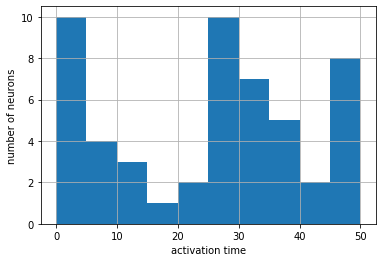

In [24]:
import pylab as pl

thres = 0.1
bools = df2_scale.iloc[:,1:] > thres

bools.sum().hist()
pl.xlabel("activation time")
pl.ylabel("number of neurons")

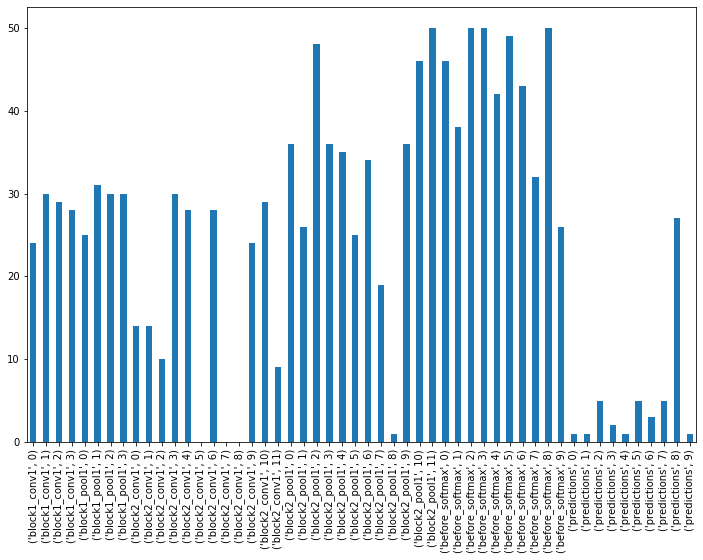

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
#print(test.index[0],test.index[0][0])

fig, axes = plt.subplots(figsize=(12, 8))
bools.sum().plot(kind="bar")